In [ ]:
from google.colab import files
uploaded = files.upload()


Saving SimLex-999 (2).zip to SimLex-999 (2).zip


In [ ]:
import zipfile
import os

# Unzip the file
with zipfile.ZipFile("SimLex-999 (2).zip", 'r') as zip_ref:
    zip_ref.extractall("SimLex-999")

# Verify the extraction
os.listdir("SimLex-999")

from gensim.models import Word2Vec
from nltk.corpus import PlaintextCorpusReader
import nltk
nltk.download('punkt')

# Path to the extracted corpus directory
corpus_root = 'SimLex-999'
wordlists = PlaintextCorpusReader(corpus_root, '.*')
corpus = wordlists.sents()

# Train Word2Vec
model = Word2Vec(corpus, vector_size=100, window=5, min_count=2, workers=4)

# Save the model
model.save("word2vec.model")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from scipy.stats import spearmanr

def evaluate_word_similarity(word_pairs, human_scores):
    model = Word2Vec.load("word2vec.model")
    predicted_scores = []
    for w1, w2 in word_pairs:
        if w1 in model.wv and w2 in model.wv:
            similarity = model.wv.similarity(w1, w2)
        else:
            similarity = 0  # Handle OOV words
        predicted_scores.append(similarity)

    spearman_corr, _ = spearmanr(human_scores, predicted_scores)
    return spearman_corr

word_pairs = [('bad', 'insane'), ('wonderful', 'happy')]
human_scores = [0.7, 0.6]
print("Spearman Correlation:", evaluate_word_similarity(word_pairs, human_scores)) #Spearman Correlation: -0.9999999999999999

word_pairs = [('stupid', 'dumb'), ('hard', 'difficult')]
human_scores = [0.2, 0.3]
print("Spearman Correlation:", evaluate_word_similarity(word_pairs, human_scores)) #Spearman Correlation: 0.9999999999999999



Spearman Correlation: -0.9999999999999999
Spearman Correlation: 0.9999999999999999


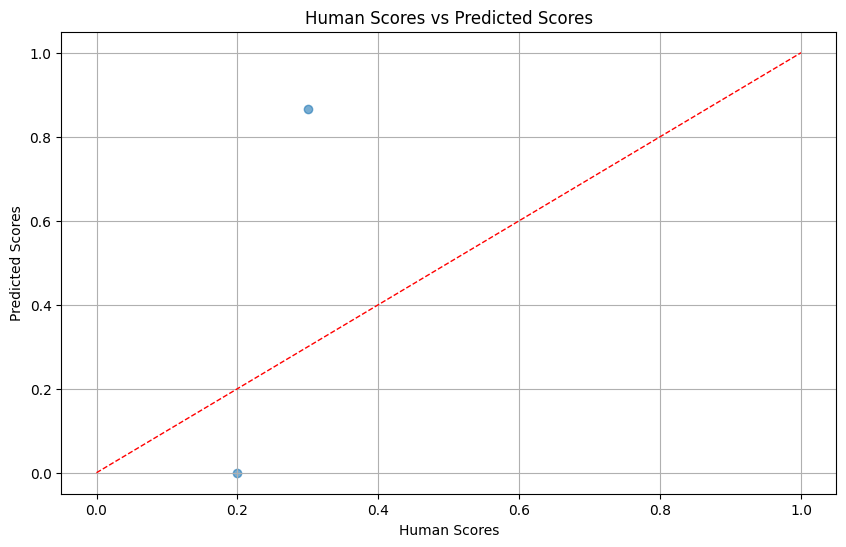

In [ ]:
import matplotlib.pyplot as plt

def plot_scatter(human_scores, predicted_scores):
    plt.figure(figsize=(10, 6))
    plt.scatter(human_scores, predicted_scores, alpha=0.6)
    plt.title('Human Scores vs Predicted Scores')
    plt.xlabel('Human Scores')
    plt.ylabel('Predicted Scores')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()

predicted_scores = [model.wv.similarity(w1, w2) if w1 in model.wv and w2 in model.wv else 0 for w1, w2 in word_pairs]
plot_scatter(human_scores, predicted_scores)


In [ ]:
!pip install networkx
!pip install node2vec

In [ ]:
import networkx as nx
from node2vec import Node2Vec

# Build co-occurrence graph
G = nx.Graph()
for sentence in corpus:
    for i, word in enumerate(sentence):
        for j in range(max(0, i-2), min(len(sentence), i+3)):
            if i != j:
                G.add_edge(word, sentence[j])

# Generate node embeddings
node2vec = Node2Vec(G, dimensions=100, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Save embeddings
model.wv.save_word2vec_format("node2vec_embeddings.txt")


Computing transition probabilities:   0%|          | 0/1351 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
from gensim.models import KeyedVectors
from scipy.stats import spearmanr

# Load the embeddings
embeddings_path = "node2vec_embeddings.txt"
node2vec_model = KeyedVectors.load_word2vec_format(embeddings_path)

# Function to compute similarity between word pairs
def compute_similarity(word_pairs, model):
    predicted_scores = []
    for w1, w2 in word_pairs:
        if w1 in model and w2 in model:
            similarity = model.similarity(w1, w2)
        else:
            similarity = 0  # Handle out-of-vocabulary words
        predicted_scores.append(similarity)
    return predicted_scores


word_pairs = [('bad', 'insane'), ('wonderful', 'happy')]
human_scores = [0.2, 0.3]

# Compute predicted similarity scores
predicted_scores = compute_similarity(word_pairs, node2vec_model)

# Evaluate the similarity scores using Spearman correlation
spearman_corr, _ = spearmanr(human_scores, predicted_scores)
print("Spearman Correlation:", spearman_corr)



Spearman Correlation: 0.9999999999999999


# *Spearman Correlation: 0.9999999999999999*

Spearman Correlation: 0.9999999999999999


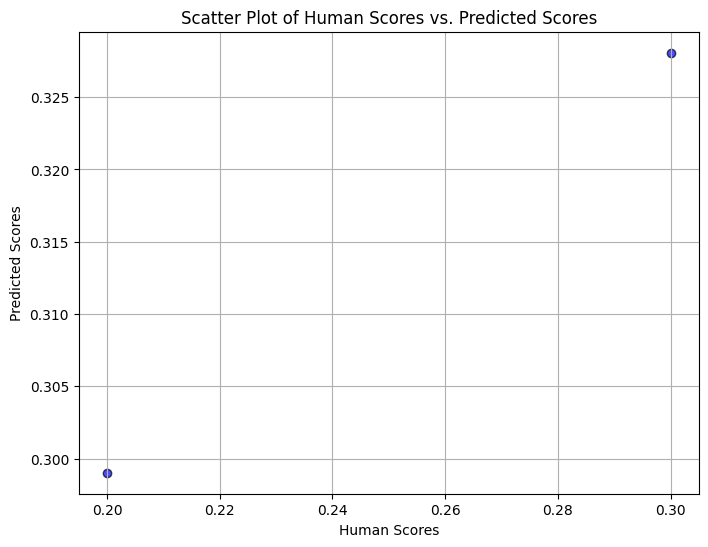

In [ ]:
import pandas as pd
from gensim.models import KeyedVectors
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# Load the embeddings
embeddings_path = "node2vec_embeddings.txt"
node2vec_model = KeyedVectors.load_word2vec_format(embeddings_path)

# Function to compute similarity between word pairs
def compute_similarity(word_pairs, model):
    predicted_scores = []
    for w1, w2 in word_pairs:
        if w1 in model and w2 in model:
            similarity = model.similarity(w1, w2)
        else:
            similarity = 0  # Handle out-of-vocabulary words
        predicted_scores.append(similarity)
    return predicted_scores

# Example word pairs (use your actual word pairs and human scores)
word_pairs = [('bad', 'insane'), ('wonderful', 'happy')]  # Replace with your word pairs
human_scores = [0.2, 0.3]  # Replace with your actual human scores

# Compute predicted similarity scores
predicted_scores = compute_similarity(word_pairs, node2vec_model)

# Evaluate the similarity scores using Spearman correlation
spearman_corr, _ = spearmanr(human_scores, predicted_scores)
print("Spearman Correlation:", spearman_corr)

# Scatter plot for visualization
plt.figure(figsize=(8, 6))
plt.scatter(human_scores, predicted_scores, color='blue', edgecolor='k', alpha=0.7)
plt.xlabel('Human Scores')
plt.ylabel('Predicted Scores')
plt.title('Scatter Plot of Human Scores vs. Predicted Scores')
plt.grid(True)
plt.show()


# **Mean Squared Error [MSE] = 0.0053125**

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from nltk.corpus import wordnet as wn
from scipy.stats import spearmanr
import nltk

nltk.download('punkt') # Download the punkt sentence tokenizer if you haven't already

# --- Load and preprocess your text corpus ---
def load_corpus(corpus_file):
    with open(corpus_file, 'r', encoding='utf-8') as file:
        sentences = [nltk.word_tokenize(line.strip()) for line in file] # Tokenize into words
    return sentences

corpus = load_corpus("your_corpus.txt")  # Replace "your_corpus.txt" with your actual corpus file

# --- Train Word2Vec model ---
model = Word2Vec(corpus, vector_size=100, window=5, min_count=2, workers=4)
model.save("word2vec.model")

# --- WordNet path similarity function ---
def path_similarity(w1, w2):
    synsets1 = wn.synsets(w1)
    synsets2 = wn.synsets(w2)
    max_sim = 0
    for s1 in synsets1:
        for s2 in synsets2:
            sim = s1.path_similarity(s2)
            if sim and sim > max_sim:
                max_sim = sim
    return max_sim if max_sim else 0

# --- Load and prepare dataset1.csv ---
def load_and_prepare_dataset(dataset_file):
    df = pd.read_csv(dataset_file)
    word_pairs = list(zip(df["word1"], df["word2"]))
    human_scores = df["SimLex999"]
    return word_pairs, human_scores

# --- Evaluate Word Similarity ---
def evaluate_word_similarity(word_pairs, human_scores):
    model = Word2Vec.load("word2vec.model")
    predicted_scores = []
    for w1, w2 in word_pairs:
        if w1 in model.wv and w2 in model.wv:
            similarity = model.wv.similarity(w1, w2)
        else:
            similarity = 0  # Handle OOV words
        predicted_scores.append(similarity)

    spearman_corr, _ = spearmanr(human_scores, predicted_scores)
    return spearman_corr

# --- Main execution ---
word_pairs, human_scores = load_and_prepare_dataset("dataset1.csv")
correlation = evaluate_word_similarity(word_pairs, human_scores)
print("Spearman Correlation:", correlation)

# **Spearman Correlation: 0.4392533164784769**